### <b>다양한 사전 학습 모델 사용하기</b>

* <b>전이 학습(transfer learning)</b>을 이용할 때, 모델의 <b>입력 차원(input demension)</b>이 정해져 있는 경우가 많다.
* 주어진 모델이 있을 때, 모델을 어떻게 사용해야 오류 없이 실행할 수 있을지 알아보자.
* 학습 코드를 실행하기 전에 <b>[런타임]</b> - <b>[런타임 유형 변경]</b>에서 하드웨어 가속기를 <b>[GPU]</b>로 설정한다.
* 가장 먼저, 딥러닝 모델 학습 과정에서 필요한 데이터 세트를 불러온다.

In [ ]:
!git clone https://github.com/ndb796/weather_dataset
%cd weather_dataset

Cloning into 'weather_dataset'...
remote: Enumerating objects: 1117, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 1117 (delta 0), reused 3 (delta 0), pack-reused 1111
Receiving objects: 100% (1117/1117), 85.23 MiB | 37.86 MiB/s, done.
/content/weather_dataset


#### <b>라이브러리 불러오기(Load Libraries)</b>

* 딥러닝 모델 학습 과정에서 필요한 라이브러리를 불러온다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np

#### <b>데이터 세트 불러오기(Load Dataset)</b>

1. <b>데이터 증진(data augmentation)</b>을 명시하여 초기화할 수 있다.
  * 이미지를 불러올 때 어떤 방법(회전, 자르기, 뒤집기 등)을 사용할 것인지 명시한다.
2. 이후에 <b>DataLoader()</b>를 이용하여 실질적으로 데이터를 불러올 수 있다.
  * 어떤 데이터를 사용할 것인지, 배치 크기(batch size), 데이터 셔플(shuffle) 여부 등을 명시한다.
  * <b>next() 함수</b>를 이용하여 tensor 형태로 데이터를 배치 단위로 얻을 수 있다.
* <b>Reference</b>: https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [ ]:
train_dataset = datasets.ImageFolder(
    root='train/',
    transform=transform_train
)
dataset_size = len(train_dataset)
train_size = int(dataset_size * 0.8)
val_size = dataset_size - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
test_dataset = datasets.ImageFolder(
    root='test/',
    transform=transform_test
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

#### <b>데이터 시각화(Data Visualization)</b>

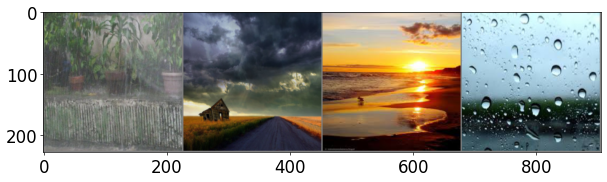

['Rain', 'Cloudy', 'Sunrise', 'Rain']


In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()

    
class_names = {
  0: "Cloudy",
  1: "Rain",
  2: "Shine",
  3: "Sunrise"
}

# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([class_names[labels[i].item()] for i in range(4)])

#### <b>딥러닝 모델 전이 학습(Transfer Learning)</b>

* 사전 학습된(pre-trained) 모델(model)을 이용하여 가지고 있는 데이터 세트에 대한 학습이 가능하다.
  * 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치시킨다.
* <b>Reference</b>: https://pytorch.org/vision/stable/models.html

#### <b>1. 사전 학습된 ResNet-50</b>

* <b>ResNet-50</b> 모델 정보를 확인할 수 있다.
1. The images are <b>resized</b> to resize_size=[256].
2. A central <b>crop</b> of crop_size=[224].
3. The values are first <b>rescaled</b> to [0.0, 1.0] and then normalized.
    * <b>mean</b>: [0.485, 0.456, 0.406].
    * <b>std</b>: [0.229, 0.224, 0.225].
* <b>Reference</b>: https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html

In [ ]:
model = models.resnet50(pretrained=True)
# print(model) # 모델 정보 출력
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

inputs = imgs.cuda()
targets = labels.cuda()

outputs = model(inputs)
print(outputs.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

torch.Size([8, 4])


#### <b>2. 사전 학습된 DenseNet-121</b>

* <b>DenseNet-121</b> 모델 정보를 확인할 수 있다.
1. The images are <b>resized</b> to resize_size=[256].
2. A central <b>crop</b> of crop_size=[224].
3. The values are first <b>rescaled</b> to [0.0, 1.0] and then normalized.
    * <b>mean</b>: [0.485, 0.456, 0.406].
    * <b>std</b>: [0.229, 0.224, 0.225].
* <b>Reference</b>: https://pytorch.org/vision/stable/models/generated/torchvision.models.densenet121.html

In [ ]:
model = models.densenet161(pretrained=True)
# print(model) # 모델 정보 출력
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

inputs = imgs.cuda()
targets = labels.cuda()

outputs = model(inputs)
print(outputs.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

torch.Size([8, 4])


#### <b>3. 사전 학습된 VGG-19</b>

* <b>VGG-19<</b> 모델 정보를 확인할 수 있다.
1. The images are <b>resized</b> to resize_size=[256].
2. A central <b>crop</b> of crop_size=[224].
3. The values are first <b>rescaled</b> to [0.0, 1.0] and then normalized.
    * <b>mean</b>: [0.485, 0.456, 0.406].
    * <b>std</b>: [0.229, 0.224, 0.225].
* <b>Reference</b>: https://pytorch.org/vision/stable/models/generated/torchvision.models.vgg19.html

In [ ]:
model = models.vgg19(pretrained=True)
# print(model) # 모델 정보 출력
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

inputs = imgs.cuda()
targets = labels.cuda()

outputs = model(inputs)
print(outputs.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

torch.Size([8, 4])


#### <b>4. 사전 학습된 EfficientNet-b0</b>

* <b>EfficientNet-b0</b> 모델 정보를 확인할 수 있다.
1. The images are <b>resized</b> to resize_size=[256].
2. A central <b>crop</b> of crop_size=[224].
3. The values are first <b>rescaled</b> to [0.0, 1.0] and then normalized.
    * <b>mean</b>: [0.485, 0.456, 0.406].
    * <b>std</b>: [0.229, 0.224, 0.225].
* <b>Reference</b>: https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html

In [ ]:
model = models.efficientnet_b0(pretrained=True)
# print(model) # 모델 정보 출력
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

inputs = imgs.cuda()
targets = labels.cuda()

outputs = model(inputs)
print(outputs.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

torch.Size([8, 4])


#### <b>5. 사전 학습된 AlexNet</b>

* <b>AlexNet</b> 모델 정보를 확인할 수 있다.
1. The images are <b>resized</b> to resize_size=[256].
2. A central <b>crop</b> of crop_size=[224].
3. The values are first <b>rescaled</b> to [0.0, 1.0] and then normalized.
    * <b>mean</b>: [0.485, 0.456, 0.406].
    * <b>std</b>: [0.229, 0.224, 0.225].
* <b>Reference</b>: https://pytorch.org/vision/stable/models/generated/torchvision.models.alexnet.html

In [ ]:
model = models.alexnet(pretrained=True)
# print(model) # 모델 정보 출력
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4) # transfer learning
model = model.cuda()

inputs = imgs.cuda()
targets = labels.cuda()

outputs = model(inputs)
print(outputs.shape)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

torch.Size([8, 4])
